In [22]:
from typing import List
from copy import deepcopy

import collections
import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})

import pyscf
import pyscf.cc
import pyscf.mcscf

# To get molecular geometries.
import openfermion as of
from openfermion import MolecularData
from openfermionpyscf import run_pyscf

import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import BitArray
from qiskit_aer import AerSimulator  # For MPS Simulator.
from qiskit.primitives import StatevectorEstimator

import ffsim

# To run on hardware.
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

from functools import partial, reduce

import numpy as np

# from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch
from qiskit_addon_sqd.qubit import solve_qubit, sort_and_remove_duplicates

from adaptvqe.pools import DVG_CEO, FullPauliPool, TiledPauliPool
from adaptvqe.convert import cirq_pauli_sum_to_qiskit_pauli_op
from adaptvqe.hamiltonians import XXZHamiltonian
from adaptvqe.algorithms.adapt_vqe import LinAlgAdapt, TensorNetAdapt

In [23]:
ibm_computer: str = "ibm_fez"

service = qiskit_ibm_runtime.QiskitRuntimeService(channel="local")
computer = service.backend()
sampler = Sampler(computer)

## Build a tiled pool

In [24]:
max_mpo_bond = 100
dmrg_mps_bond = 10
adapt_mps_bond = 10
l = 4

j_xy = 1
j_z = 1
h = XXZHamiltonian(j_xy, j_z, l, diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond)
dmrg_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")
pool = FullPauliPool(n=l, max_mpo_bond=max_mpo_bond)

# Run 200 iterations of ADAPT-VQE for small problem instance, selecting randomly among degenerate gradients.
# Form a list of all unique operators ever selected for this small instance.
ixs = []
for _ in range(30):
    my_adapt = TensorNetAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=False,
        threshold=10**-5,
        max_adapt_iter=5,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=100,
        max_mps_bond = 20
    )
    my_adapt.run()
    data = my_adapt.data
    for i in data.result.ansatz.indices:
        if i not in ixs:
            ixs.append(i)

print(f"Pool will be tiled from {len(ixs)} ops")
source_ops = [pool.operators[index].operator for index in ixs]

Got DMRG energy -6.46410e+00

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.000000000000005)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operators under consideration (1):
[79]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.000000000000007)]
Operator(s) added to ansatz: [79]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 79]...
Starting point: [np.float64(0.5535743588970456), np.float64(0.0

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526200768382
Operators under consideration (1):
[156]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.4850710481682663)]
Operator(s) added to ansatz: [156]
Initial energy: -6.1231056256176455
Optimizing energy with indices [244, 79, 216, 156]...
Starting point: [np.float64(0.7853981633974504), np.float64(0.7853981633974519), np.float64(-0.1224892795338588), np.float64(0.0)]

Current energy: -6.327276154819707
(change of -0.20417052920206125)
Current ansatz: [244, 79, 216, 156]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531914
Operators under consideration (1):
[225]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0894929267348785)]
Operator(s) added to ansatz: [225]
Initial energy: -6.327276154819707
Optimizing energy with indices [244, 79, 216, 156, 225]...
Starting point: [np.float64(0.7853981633974342), np.float64(0.7853981633975554), np.flo

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819971
(change of -0.2041705292023286)
Current ansatz: [241, 74, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964057733311
Operators under consideration (1):
[198]
Corresponding gradients (ordered by magnitude):
[np.float64(2.089491629507777)]
Operator(s) added to ansatz: [198]
Initial energy: -6.327276154819971
Optimizing energy with indices [241, 74, 228, 210, 198]...
Starting point: [np.float64(-0.785398162447052), np.float64(-0.7853981711958521), np.float64(0.16357028748210503), np.float64(0.16356997569593643), np.float64(0.0)]

Current energy: -6.464101615072614
(change of -0.1368254602526422)
Current ansatz: [241, 74, 228, 210, 198]
Performing final convergence check...
Total gradient norm: 0.00013515787565729383

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964057733311 > 1e-05)

Ini

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000014
(change of -1.7639320225002155)
Current ansatz: [244, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132747
Operators under consideration (1):
[228]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0000000000000018)]
Operator(s) added to ansatz: [228]
Initial energy: -6.000000000000014
Optimizing energy with indices [244, 26, 228]...
Starting point: [np.float64(0.7853981718257763), np.float64(0.7853981815917102), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617647
(change of -0.12310562561763305)
Current ansatz: [244, 26, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199440323
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.485071047428078)]
Operator(s) added to ansatz: [210]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 26, 228, 210]...
Starting point: [np.float64(0.7853981611549227), np.float64(0.7853981650265573), np.float64(0.1224892793431165), np.float64(0.0)]

Current energy: -6.32727615481998
(change of -0.20417052920233303)
Current ansatz: [244, 26, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964040371926
Operators under consideration (1):
[147]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0894916447538887)]
Operator(s) added to

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819991
(change of -0.2041705292023357)
Current ansatz: [244, 31, 216, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042638306
Operators under consideration (1):
[156]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0894916427634778)]
Operator(s) added to ansatz: [156]
Initial energy: -6.327276154819991
Optimizing energy with indices [244, 31, 216, 225, 156]...
Starting point: [np.float64(0.7853981628939728), np.float64(-0.7853981669250067), np.float64(-0.16357028656166703), np.float64(-0.16356997223173272), np.float64(0.0)]

Current energy: -6.464101615072754
(change of -0.136825460252763)
Current ansatz: [244, 31, 216, 225, 156]
Performing final convergence check...
Total gradient norm: 0.00013507009850829437

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964042638306 > 1e-05)



/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442571
Operators under consideration (1):
[135]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.4850710474293334)]
Operator(s) added to ansatz: [135]
Initial energy: -6.12310562561764
Optimizing energy with indices [241, 26, 225, 135]...
Starting point: [np.float64(-0.7853981643039402), np.float64(0.785398162943446), np.float64(-0.12248927934344042), np.float64(0.0)]

Current energy: -6.327276154819694
(change of -0.20417052920205414)
Current ansatz: [241, 26, 225, 135]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531778
Operators under consideration (1):
[57]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0894929267348736)]
Operator(s) added to ansatz: [57]
Initial energy: -6.327276154819694
Optimizing energy with indices [241, 26, 225, 135, 57]...
Starting point: [np.float64(-0.7853981689169396), np.float64(0.7853981615043121), np.float6

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526200048677
Operators under consideration (1):
[198]
Corresponding gradients (ordered by magnitude):
[np.float64(2.485071047767142)]
Operator(s) added to ansatz: [198]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 225, 198]...
Starting point: [np.float64(0.7853981633976963), np.float64(-0.7853981633977503), np.float64(-0.12248927943049101), np.float64(0.0)]

Current energy: -6.327276154819957
(change of -0.20417052920230994)
Current ansatz: [244, 74, 225, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.2409640413812895
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.089491643867186)]
Operator(s) added to ansatz: [210]
Initial energy: -6.327276154819957
Optimizing energy with indices [244, 74, 225, 198, 210]...
Starting point: [np.float64(0.7853981633827103), np.float64(-0.7853981633905597), np.fl

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operators under consideration (1):
[216]
Corresponding gradients (ordered by magnitude):
[np.float64(2.000000000000005)]
Operator(s) added to ansatz: [216]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 216]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.1231056256176455
(change of -0.1231056256176366)
Current ansatz: [244, 79, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200768382
Operators under consideration (1):
[156]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.4850710481682663)]
Operator(s) added to ansatz: [156]
Initial energy: -6.1231056256176

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00029671020679084166

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041381052 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.000000000000005)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operators under consideration (1):
[79]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.000000000000007)]
Operator(s) ad

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operators under consideration (1):
[228]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.000000000000001)]
Operator(s) added to ansatz: [228]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operators under consideration (1):
[198]
Corresponding gradients (ordered by magnitude):
[np.float64(2.485071047429203)]
Operator(s) added to ansatz: [198]
Initial energy: -6.12310562561763

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999929518
(change of -1.7639320224297226)
Current ansatz: [228, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971647986
Operators under consideration (1):
[228]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.000000000019367)]
Operator(s) added to ansatz: [228]
Initial energy: -5.999999999929518
Optimizing energy with indices [228, 79, 228]...
Starting point: [np.float64(-0.7853947065773552), np.float64(0.7853993777262496), np.float64(0.0)]

Current energy: -6.123105625562482
(change of -0.1231056256329639)
Current ansatz: [228, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526201775814
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.4850710484682814)]
Operator(s) added to ansatz: [210]
Initial energy: -6.123105625562

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operators under consideration (1):
[228]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.000000000000001)]
Operator(s) added to ansatz: [228]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operators under consideration (1):
[198]
Corresponding gradients (ordered by magnitude):
[np.float64(2.485071047429203)]
Operator(s) added to ansatz: [198]
Initial energy: -6.12310562561763

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.000000000000006)]
Operator(s) added to ansatz: [210]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 210]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617651
(change of -0.12310562561764193)
Current ansatz: [244, 79, 210]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752619964306
Operators under consideration (1):
[201]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.4850710475410684)]
Operator(s) added to ansatz: [201]
Initial energy: -6.1231056256176

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101614752833
(change of -0.13682545993280115)
Current ansatz: [244, 79, 210, 201, 225]
Performing final convergence check...
Total gradient norm: 0.00023661535824530413

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240963744097293 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.000000000000005)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 6.240962580531926
Operators under consideration (1):
[225]
Corresponding gradients (ordered by magnitude):
[np.float64(2.089492926734938)]
Operator(s) added to ansatz: [225]
Initial energy: -6.327276154819703
Optimizing energy with indices [244, 31, 216, 156, 225]...
Starting point: [np.float64(0.7853981632610946), np.float64(-0.7853981632121824), np.float64(-0.16357019740840975), np.float64(0.1635696366828712), np.float64(0.0)]

Current energy: -6.464101615135387
(change of -0.1368254603156842)
Current ansatz: [244, 31, 216, 156, 225]
Performing final convergence check...
Total gradient norm: 2.5888765705329522e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580531926 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operators under consideration (

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819971
(change of -0.2041705292023286)
Current ansatz: [241, 74, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964057733311
Operators under consideration (1):
[147]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0894916295077772)]
Operator(s) added to ansatz: [147]
Initial energy: -6.327276154819971
Optimizing energy with indices [241, 74, 228, 210, 147]...
Starting point: [np.float64(-0.785398162447052), np.float64(-0.7853981711958521), np.float64(0.16357028748210503), np.float64(0.16356997569593643), np.float64(0.0)]

Current energy: -6.464101615072577
(change of -0.13682546025260578)
Current ansatz: [241, 74, 228, 210, 147]
Performing final convergence check...
Total gradient norm: 0.00013515787616504767

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964057733311 > 1e-05)

I

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617644
(change of -0.12310562561763749)
Current ansatz: [244, 31, 198]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526201327165
Operators under consideration (1):
[216]
Corresponding gradients (ordered by magnitude):
[np.float64(2.485071048479704)]
Operator(s) added to ansatz: [216]
Initial energy: -6.123105625617644
Optimizing energy with indices [244, 31, 198, 216]...
Starting point: [np.float64(0.7853981648268568), np.float64(-0.7853981619177081), np.float64(-0.12248927961411428), np.float64(0.0)]

Current energy: -6.327276154819966
(change of -0.20417052920232237)
Current ansatz: [244, 31, 198, 216]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096404241015
Operators under consideration (1):
[78]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0894916429638792)]
Operator(s) added 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000011
(change of -1.7639320225002146)
Current ansatz: [241, 31]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132743
Operators under consideration (1):
[225]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0000000000000018)]
Operator(s) added to ansatz: [225]
Initial energy: -6.000000000000011
Optimizing energy with indices [241, 31, 225]...
Starting point: [np.float64(-0.7853981718257756), np.float64(-0.7853981815917112), np.float64(0.0)]

Current energy: -6.123105625617648
(change of -0.12310562561763749)
Current ansatz: [241, 31, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752619944177
Operators under consideration (1):
[147]
Corresponding gradients (ordered by magnitude):
[np.float64(2.4850710474288826)]
Operator(s) added to ansatz: [147]
Initial energy: -6.123105625617

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000014
(change of -1.7639320225002155)
Current ansatz: [244, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132747
Operators under consideration (1):
[228]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0000000000000018)]
Operator(s) added to ansatz: [228]
Initial energy: -6.000000000000014
Optimizing energy with indices [244, 26, 228]...
Starting point: [np.float64(0.7853981718257763), np.float64(0.7853981815917102), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561763305)
Current ansatz: [244, 26, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199440323
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.485071047428078)]
Operator(s) added to ansatz: [210]
Initial energy: -6.123105625617

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101615058578
(change of -0.13682546023859743)
Current ansatz: [244, 26, 228, 210, 147]
Performing final convergence check...
Total gradient norm: 0.0001435936123970028

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964040371926 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.000000000000005)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.8533

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 9.797958971132747
Operators under consideration (1):
[228]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0000000000000018)]
Operator(s) added to ansatz: [228]
Initial energy: -6.000000000000014
Optimizing energy with indices [244, 26, 228]...
Starting point: [np.float64(0.7853981718257763), np.float64(0.7853981815917102), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561763305)
Current ansatz: [244, 26, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199440323
Operators under consideration (1):
[120]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.4850710474280784)]
Operator(s) added to ansatz: [120]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 26, 228, 120]...
Starting point: [np.float64(0.7853981611549227), np.float64(0.7853981650265573), np.float64(0.1224892793431165), np.float64(0.0)]

Current energy: -6.327276154819986
(change of -0.20417052920233836)
Current ansatz: [244, 26, 228, 120]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964051651328
Operators under consideration (1):
[108]
Corresponding gradients (ordered by magnitude):
[np.float64(2.089491634849078)]
Operator(s) added to ansatz: [108]
Initial energy: -6.327276154819986
Optimizing energy with indices [244, 26, 228, 120, 108]...
Starting point: [np.float64(0.7853981688543166), np.float64(0.7853981542419118), np.float6

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999929518
(change of -1.7639320224297226)
Current ansatz: [228, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971647986
Operators under consideration (1):
[216]
Corresponding gradients (ordered by magnitude):
[np.float64(1.999999999952205)]
Operator(s) added to ansatz: [216]
Initial energy: -5.999999999929518
Optimizing energy with indices [228, 79, 216]...
Starting point: [np.float64(-0.7853947065773552), np.float64(0.7853993777262496), np.float64(0.0)]

Current energy: -6.1231056252069065
(change of -0.12310562527738877)
Current ansatz: [228, 79, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917518430081312
Operators under consideration (1):
[225]
Corresponding gradients (ordered by magnitude):
[np.float64(2.485066714324805)]
Operator(s) added to ansatz: [225]
Initial energy: -6.1231056252069

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526201775825
Operators under consideration (1):
[135]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.485071048468284)]
Operator(s) added to ansatz: [135]
Initial energy: -6.12310562556249
Optimizing energy with indices [225, 74, 228, 135]...
Starting point: [np.float64(0.7853947065772676), np.float64(-0.7853985308794365), np.float64(0.1224892796166996), np.float64(0.0)]

Current energy: -6.327276154765016
(change of -0.20417052920252665)
Current ansatz: [225, 74, 228, 135]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.2409640420691685
Operators under consideration (1):
[198]
Corresponding gradients (ordered by magnitude):
[np.float64(2.089491643863285)]
Operator(s) added to ansatz: [198]
Initial energy: -6.327276154765016
Optimizing energy with indices [225, 74, 228, 135, 198]...
Starting point: [np.float64(0.7853947065771415), np.float64(-0.7853982468601413), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819977
(change of -0.20417052920233392)
Current ansatz: [244, 31, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964044667907
Operators under consideration (1):
[147]
Corresponding gradients (ordered by magnitude):
[np.float64(2.089491640981468)]
Operator(s) added to ansatz: [147]
Initial energy: -6.327276154819977
Optimizing energy with indices [244, 31, 228, 210, 147]...
Starting point: [np.float64(0.7853981417276958), np.float64(-0.7853981819240415), np.float64(0.1635702866854681), np.float64(0.16356997269745452), np.float64(0.0)]

Current energy: -6.464101615071121
(change of -0.13682546025114384)
Current ansatz: [244, 31, 228, 210, 147]
Performing final convergence check...
Total gradient norm: 0.000136128583548991

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964044667907 > 1e-05)

Init

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002093)
Current ansatz: [241, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132733
Operators under consideration (1):
[216]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0000000000000036)]
Operator(s) added to ansatz: [216]
Initial energy: -6.000000000000005
Optimizing energy with indices [241, 79, 216]...
Starting point: [np.float64(-0.785398171825775), np.float64(0.7853981815917083), np.float64(0.0)]

Current energy: -6.123105625617644
(change of -0.12310562561763838)
Current ansatz: [241, 79, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200767302
Operators under consideration (1):
[225]
Corresponding gradients (ordered by magnitude):
[np.float64(2.485071048167666)]
Operator(s) added to ansatz: [225]
Initial energy: -6.12310562561764

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819948
(change of -0.2041705292023046)
Current ansatz: [241, 79, 216, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964115398415
Operators under consideration (1):
[201]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0894915788711836)]
Operator(s) added to ansatz: [201]
Initial energy: -6.327276154819948
Optimizing energy with indices [241, 79, 216, 225, 201]...
Starting point: [np.float64(-0.7853982205487021), np.float64(0.7853982043140048), np.float64(-0.16357029099862372), np.float64(-0.1635699889292778), np.float64(0.0)]

Current energy: -6.464101614697422
(change of -0.13682545987747385)
Current ansatz: [241, 79, 216, 225, 201]
Performing final convergence check...
Total gradient norm: 0.0002805605397347146

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964115398415 > 1e-05)



/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441697
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.485071047428846)]
Operator(s) added to ansatz: [210]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 210]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819982
(change of -0.20417052920234013)
Current ansatz: [241, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096404138082
Operators under consideration (1):
[147]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0894916438682527)]
Operator(s) added to ansatz: [147]
Initial energy: -6.327276154819982
Optimizing energy with indices [241, 79, 228, 210, 147]...
Starting point: [np.float64(-0.7853982024976439), np.float64(0.7853981311150512), np.float64(0.1635702864850446), np.float64(0.16356997194303877), np.float64(0.0)]

Current energy: -6.464101614554787
(change of -0.13682545973480487)
Current ansatz: [241, 79, 228, 210, 147]
Performing final convergence check...
Total gradient norm: 0.00033002084338061577

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096404138082 > 1e-05)

Ini

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526543082344
Operators under consideration (1):
[180]
Corresponding gradients (ordered by magnitude):
[np.float64(2.485071238945678)]
Operator(s) added to ansatz: [180]
Initial energy: -6.123105625615372
Optimizing energy with indices [198, 180, 31, 180]...
Starting point: [np.float64(-0.12248932869755463), np.float64(0.785397813943876), np.float64(-0.785397228867723), np.float64(0.0)]

Current energy: -6.327276154817688
(change of -0.20417052920231615)
Current ansatz: [198, 180, 31, 180]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962166882978
Operators under consideration (1):
[201]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.089491623947855)]
Operator(s) added to ansatz: [201]
Initial energy: -6.327276154817688
Optimizing energy with indices [198, 180, 31, 180, 201]...
Starting point: [np.float64(-0.16356985697006937), np.float64(0.7853978139438187), np.floa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752620004858
Operators under consideration (1):
[198]
Corresponding gradients (ordered by magnitude):
[np.float64(2.4850710477670868)]
Operator(s) added to ansatz: [198]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 228, 198]...
Starting point: [np.float64(0.7853981659552435), np.float64(-0.7853981611613353), np.float64(0.12248927943047701), np.float64(0.0)]

Current energy: -6.327276154819701
(change of -0.20417052920205414)
Current ansatz: [244, 74, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531868
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0894929267348714)]
Operator(s) added to ansatz: [210]
Initial energy: -6.327276154819701
Optimizing energy with indices [244, 74, 228, 198, 210]...
Starting point: [np.float64(0.7853981767050704), np.float64(-0.7853981525341414), np.flo

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002066)
Current ansatz: [244, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.79795897113273
Operators under consideration (1):
[228]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0000000000000004)]
Operator(s) added to ansatz: [228]
Initial energy: -6.000000000000005
Optimizing energy with indices [244, 74, 228]...
Starting point: [np.float64(0.7853981703433218), np.float64(-0.7853981783720295), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617647
(change of -0.12310562561764193)
Current ansatz: [244, 74, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752620004858
Operators under consideration (1):
[198]
Corresponding gradients (ordered by magnitude):
[np.float64(2.4850710477670868)]
Operator(s) added to ansatz: [198]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 228, 198]...
Starting point: [np.float64(0.7853981659552435), np.float64(-0.7853981611613353), np.float64(0.12248927943047701), np.float64(0.0)]

Current energy: -6.327276154819701
(change of -0.20417052920205414)
Current ansatz: [244, 74, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531868
Operators under consideration (1):
[135]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0894929267348714)]
Operator(s) added

## Run ADAPT at larger size to get a sequence of circuits.

In [25]:
def neel_circuit(nq, start_zero=True):
    circuit = QuantumCircuit(nq)
    for i in range(nq):
        if (i % 2 == 0 and start_zero) or (i % 2 != 0 and not start_zero):
            circuit.x(i)
        else:
            circuit.id(i)
    return circuit

In [26]:
# Now go to the larger size.
new_l = 2 * l
j_xy = 1
j_z = 1
h = XXZHamiltonian(
    j_xy, j_z, new_l,
    store_ref_vector=False,
    diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond
)
dmrg_energy = h.ground_energy
exact_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")

h_of = h.operator
h_cirq = of.transforms.qubit_operator_to_pauli_sum(h_of)
h_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(h_cirq)

tiled_pool = TiledPauliPool(n=new_l, source_ops=source_ops)
num_ops = len(tiled_pool.operators)
print(f"Tiled pool has {num_ops} operators.")

tn_adapt = TensorNetAdapt(
    pool=tiled_pool,
    custom_hamiltonian=h,
    verbose=True,
    threshold=10**-5,
    max_adapt_iter=30,
    max_opt_iter=10000,
    sel_criterion="gradient",
    recycle_hessian=False,
    rand_degenerate=True,
    max_mpo_bond=max_mpo_bond,
    max_mps_bond=adapt_mps_bond
)
tn_adapt.initialize()
nq = tn_adapt.n

circuits = []
adapt_energies = []
for i in range(10):
    print(f"On iteration {i}.")
    tn_adapt.run_iteration()
    data = tn_adapt.data
    ansatz_circuit = pool.get_circuit(tn_adapt.indices, tn_adapt.coefficients)
    print("coefficients:", tn_adapt.coefficients)
    print("indices:", tn_adapt.indices)
    # Prepare the HF reference state, then add the Ansatz circuit.
    q = QuantumRegister(nq)
    circuit = QuantumCircuit(q)
    ref_circuit = neel_circuit(nq, start_zero=False)
    circuit = circuit.compose(ref_circuit)
    circuit = circuit.compose(ansatz_circuit)
    circuit.measure_all()
    circuits.append(circuit)
    adapt_energies.append(tn_adapt.energy)

Got DMRG energy -1.34997e+01
Tiled pool has 101 operators.

tensor-net-adapt prepared with the following settings:
> Pool: tiled_pauli_pool
> Custom Hamiltonian: XXZ_1_1
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: False
> Tetris: False (progressive optimization: False)
> Convergence threshold (gradient norm):  1e-05
> Maximum number of iterations:  30
> candidates per iteration:  1

Initial energy: -6.999999999999975
On iteration 0.

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -3.99999999999997
Operator 1: 3.999999999999984
Operator 2: -3.9999999999999902
Operator 3: 3.999999999999996
Operator 4: -3.9999999999999947
Operator 5: -3.9999999999999862
Operator 6: 3.999999999999985
Operator 17: -3.99999999999997
Operator 18: -3.999999999999984
Operator 19: -3.9999999999999902
Operator 20: -3.999999999999996
Operator

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.732445
         Iterations: 7
         Function evaluations: 51
         Gradient evaluations: 40

Current energy: -9.732444564744316
(change of -1.075590315251965)
Current ansatz: [77, 99, 50]
coefficients: [np.float64(-0.46089812389086837), np.float64(0.46089809185480723), np.float64(-0.5135775287959927)]
indices: [77, 99, 50]
On iteration 3.

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -2.243291613927854
Operator 2: -2.2432917160189128
Operator 3: 1.5827863819595223e-07
Operator 4: -3.208780266942793
Operator 5: -3.2087801648517402
Operator 6: -1.6341357931458366e-07
Operator 7: -1.5933770781145773
Operator 8: 1.7116617836857786
Operator 9: -1.7116617836857873
Operator 10: 1.59337700066547
Operator 11: -1.5933770006654708
Operator 12: 0.8241834150024947
Operator 13: -1.7116617836857804
Operator 14: 0.6252484870685793
Operator 15: -1.593377000665

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -12.581956
         Iterations: 16
         Function evaluations: 51
         Gradient evaluations: 39

Current energy: -12.581956236905867
(change of -0.19893362889260224)
Current ansatz: [77, 99, 50, 26, 5, 43, 51, 11]
coefficients: [np.float64(-0.13297437650188018), np.float64(0.17105038819755683), np.float64(-0.1422344871407431), np.float64(-0.7180181487360465), np.float64(0.6941070321050784), np.float64(-0.6397045503848708), np.float64(0.6476435165801311), np.float64(-0.1641818897401487)]
indices: [77, 99, 50, 26, 5, 43, 51, 11]
On iteration 8.

*** ADAPT-VQE Iteration 9 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -0.1262986491041202
Operator 1: 0.628132541219187
Operator 2: -0.17361376864007141
Operator 3: 0.2960483729181918
Operator 4: 0.1073822629126091
Operator 6: 0.6299424994046184
Operator 7: 2.42361413115629
Operator 8: 0.25767962981560194
Operator 9: 2.31699003751

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


In [27]:
for circuit in circuits:
    print(circuit.depth())

9
16
23
30
39
44
49
56
65
74


Text(0, 0.5, 'Energy error')

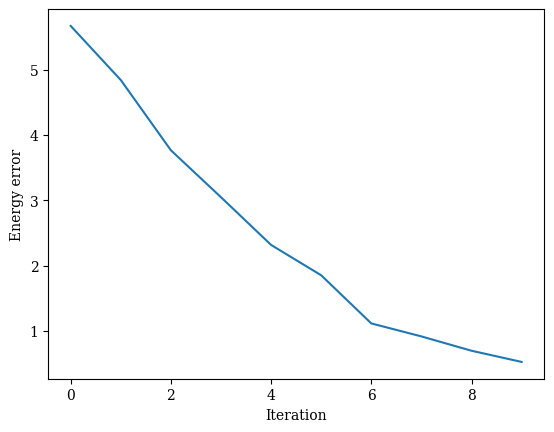

In [28]:
fig, ax = plt.subplots()
ax.plot(abs(np.array(adapt_energies) - exact_energy))
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

In [29]:
adapt_errors = np.abs(np.array(adapt_energies) - exact_energy)

## Carry out SQD.

In [30]:
# Use a fake computer to get noise.
computer = qiskit_ibm_runtime.fake_provider.FakeTorino()
simualtor = AerSimulator(method="matrix_product_state").from_backend(computer)
sampler = Sampler(simualtor)

In [31]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

spin_a_layout = list(range(0, 12))
spin_b_layout = [12, 13, 14, 15, 19, 35, 34, 33, 32, 31, 30, 29]
initial_layout = spin_a_layout + spin_b_layout

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=computer, initial_layout=initial_layout[:nq]
)


In [32]:
bit_arrays = []
counts_list = []
for circuit in circuits:
    pass_manager.pre_init = ffsim.qiskit.PRE_INIT
    to_run = pass_manager.run(circuit)
    print(f"Gate counts (w/ pre-init passes): {to_run.count_ops()}")
    job = sampler.run([to_run], shots=30_000)
    bit_array = job.result()[0].data.meas
    counts1 = bit_array.get_counts()
    counts_list.append(counts1)
    bit_arrays.append(deepcopy(bit_array))

Gate counts (w/ pre-init passes): OrderedDict({'rz': 11, 'sx': 10, 'measure': 8, 'cz': 7, 'x': 5, 'barrier': 2})
Gate counts (w/ pre-init passes): OrderedDict({'rz': 23, 'sx': 23, 'cz': 14, 'x': 8, 'measure': 8, 'barrier': 3})
Gate counts (w/ pre-init passes): OrderedDict({'sx': 34, 'rz': 32, 'cz': 21, 'x': 8, 'measure': 8, 'barrier': 4})
Gate counts (w/ pre-init passes): OrderedDict({'sx': 49, 'rz': 46, 'cz': 30, 'measure': 8, 'x': 6, 'barrier': 5})
Gate counts (w/ pre-init passes): OrderedDict({'sx': 63, 'rz': 62, 'cz': 36, 'x': 9, 'measure': 8, 'barrier': 6})
Gate counts (w/ pre-init passes): OrderedDict({'sx': 73, 'rz': 72, 'cz': 40, 'x': 8, 'measure': 8, 'barrier': 7})
Gate counts (w/ pre-init passes): OrderedDict({'sx': 86, 'rz': 83, 'cz': 45, 'x': 11, 'barrier': 8, 'measure': 8})
Gate counts (w/ pre-init passes): OrderedDict({'sx': 100, 'rz': 96, 'cz': 50, 'x': 11, 'barrier': 9, 'measure': 8})
Gate counts (w/ pre-init passes): OrderedDict({'rz': 99, 'sx': 99, 'cz': 52, 'x': 11, 

In [33]:
energies = []
errors = []

for bit_array in bit_arrays:
    print(bit_array.num_bits)
    bit_matrix = bit_array.to_bool_array()
    print(bit_matrix.shape)
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    energies.append(min_energy)
    errors.append(err)

8
(30000, 8)
8
(30000, 8)
8
(30000, 8)
8
(30000, 8)
8
(30000, 8)
8
(30000, 8)
8
(30000, 8)
8
(30000, 8)
8
(30000, 8)
8
(30000, 8)


Text(0, 0.5, 'Energy error')

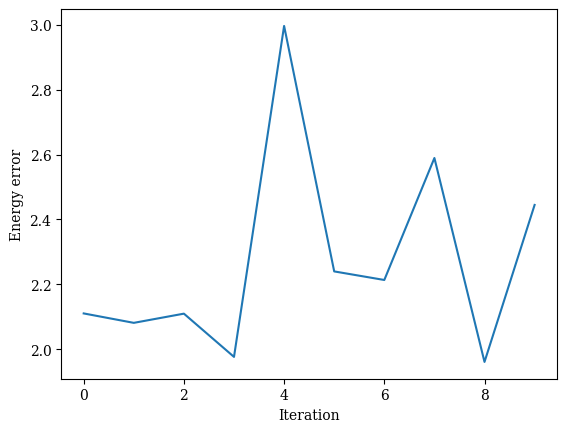

In [34]:
fig, ax = plt.subplots()
ax.plot(errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Concatenate mulitple rounds

In [35]:
stacked_energies = []
stacked_errors = []

for i in range(1, len(counts_list) + 1):
    all_counts = collections.Counter()
    tuple_of_counts = tuple(counts_list[:i])
    assert len(tuple_of_counts) == i
    for counts in tuple_of_counts:
        for bitstring, count in counts.items():
            all_counts[bitstring] += count

    bit_array = qiskit.primitives.BitArray.from_counts(all_counts)
    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    stacked_energies.append(min_energy)
    stacked_errors.append(err)


Text(0, 0.5, 'Energy error')

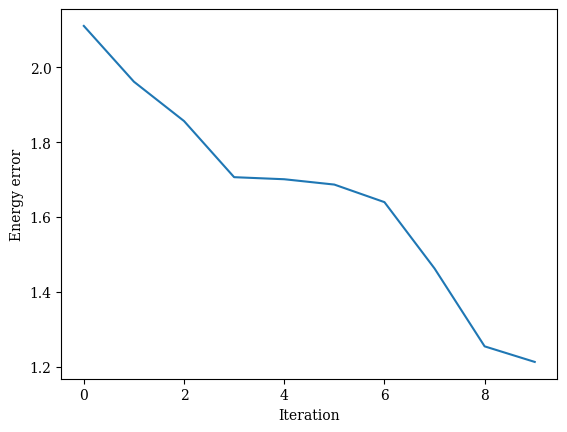

In [36]:
fig, ax = plt.subplots()
ax.plot(stacked_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Random sampling

Instead of sampling from an approximation of the ground state, make a truly random array of bits.

In [37]:
from qiskit_addon_sqd.counts import generate_bit_array_uniform

bit_array = generate_bit_array_uniform(30_000, nq, rand_seed=1)

In [38]:
bit_matrix = bit_array.to_bool_array()
eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit)
min_energy_random = np.min(eigvals)
err_random = abs(min_energy - exact_energy)
rel_err_random = err_random / abs(exact_energy)

## Plot final results

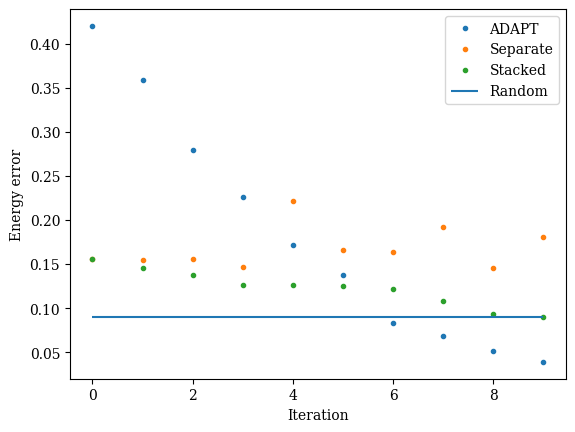

In [39]:
adapt_rel_errors = adapt_errors / abs(exact_energy)
rel_errors = np.array(errors) / abs(exact_energy)
stacked_rel_errors = np.array(stacked_errors) / abs(exact_energy)

fig, ax = plt.subplots()
ax.plot(adapt_rel_errors, '.', label="ADAPT")
ax.plot(rel_errors, '.', label="Separate")
ax.plot(stacked_rel_errors, '.', label="Stacked")
ax.hlines(rel_err_random, 0., len(rel_errors) - 1, label="Random")
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")
ax.legend()